# Symboic Functions (Functors)

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/google/pyglove/blob/main/docs/notebooks/intro/basics/symbolic_function.ipynb)

PyGlove introduces the concept of symbolic functions (or functors). A symbolic function is the symbolic counterpart of Python functions. Implementation-wise, it is a symbolic class with a `__call__` method that invokes the function body. 

Symbolic function provides the following benefits:

* It converts functions to classes, thus the use of functors can make a Python program more OO;
* It adds advanced binding capabilities, from full binding, partial binding, incremental binding, mutable binding to binding cloning, binding serialization, and etc.
* It can be symbolically programmed, supporting features such as deep manipulation, symbolic query, generation and optimization.

**Table of Contents**

* [Definition](#definition)
* [Advanced Binding Capabilities](#binding-capabilities)
* [Symbolic Programmability](#symbolic-programmability)
* [Appendix: Various Binding Scenarios With `functools.partial`](#functools-partial)


Before we get started, we install and import the pyglove library:

In [ ]:
!pip install pyglove

In [ ]:
import pyglove as pg

<a name='definition'></a>
## Definition

A functor can be created by decorating a function definition with `pg.symbolize`, for example:

In [ ]:
@pg.symbolize
def foo(fn, v):
  return v + fn(v)

@pg.symbolize
def bar(x, y):
  return x + y

print(foo)
print(bar)

<class '__main__.foo'>
<class '__main__.bar'>


It can also be created by symbolize an existing function (without modifying it).

In [ ]:
def baz(x, y, z):
  return x * y * z

bax = pg.symbolize(baz)
print(bax)
print(baz)

<class '__main__.baz'>
<function baz at 0x7fecf4f4a0d0>


To call a symbolic function, we need to create an instance first:

In [ ]:
# `f` is an instance of `foo`,
# whose `fn` argument is a partially bound `bar` object.
f = foo(bar(y=1), 2)
print(f)

# Call the symbolic function.
f()

foo(
  fn = bar(
    x = MISSING_VALUE(Any()),
    y = 1
  ),
  v = 2
)


5

<a name='binding-capabilities'></a>
## Advanced Binding Capabilities

Functor supports various binding scenarios, from partial binding, incremental binding, to mutable binding, and etc.

### Partial binding 

As we have seen above (`bar(y=1)`), a functor object can be created with arguments partially bound. The unbound arguments are marked as `pg.MISSING_VALUE`.

In [ ]:
# `f2` is a partially bound `foo` with `v`.
f2 = foo(v=1)
print(f2)

# Tell whether a functor is fully bound or not.
print(f2.is_fully_bound)

foo(
  fn = MISSING_VALUE(Any()),
  v = 1
)
False


Bound arguments and unbound arguments can be accessed via the `bound_args` or `unbound_args` property.

In [ ]:
print('bound args', f2.bound_args)
print('unbound args', f2.unbound_args)

bound args {'v'}
unbound args {'fn'}


### Incremental binding

Unbound arguments can be provided at call time. However, a call-time provided argument will not be considered as a bound argument. It's used for that particular invocation and not assoicated with the functor. For example:

In [ ]:
# Passing `y=2` at call time does not cause `y` to bind with the value.
print(f2(fn=bar(y=1)))
print(f2)
print(f2(fn=bar(y=3)))

3
foo(
  fn = MISSING_VALUE(Any()),
  v = 1
)
5


On the other hand, users can also incrementally bind arguments through attribute assignment, which will be treated as bound arguments:

In [ ]:
f2.fn = bar(y=1)
print(f2)
print(f2())

foo(
  fn = bar(
    x = MISSING_VALUE(Any()),
    y = 1
  ),
  v = 1
)
3


### Mutable binding

If users want to modify a preexisting bound argument, attribute assignment can help:

In [ ]:
f2.v = 2
print(f2)
f2()

foo(
  fn = bar(
    x = MISSING_VALUE(Any()),
    y = 1
  ),
  v = 2
)


5

If users only want to override the argument at call time, but not modifying the bound argument, they can specify that argument with a new value during call, and set the `override_args` flag to `True`.

In [ ]:
f2(v=3, override_args=True)

# f2.v remains bound with value 2.
print(f2)

foo(
  fn = bar(
    x = MISSING_VALUE(Any()),
    y = 1
  ),
  v = 2
)


### Sealed binding

If users want to prevent the bound arguments from future modification, they can seal such functor. Further update on the functor will raise an error.

In [ ]:
f2.seal()
try:
  f2.v = 3
except pg.WritePermissionError as e:
  print(e)

Cannot set attribute 'v': object is sealed. (path=)


### Clone a binding

A functor object can also be cloned:

In [ ]:
f3 = f2.clone()
f3

foo(fn=bar(x=MISSING_VALUE, y=1), v=2)

### Serialize a binding

A functor object can also be serialized for later use, or picked up by a different process (given the arguments are serializable by PyGlove).

In [ ]:
serialized_form = f2.to_json_str()
serialized_form

'{"_type": "__main__.foo", "fn": {"_type": "__main__.bar", "y": 1}, "v": 2}'

Loading it is simple, just make sure the module that defines the functor class is pre-imported:

In [ ]:
f4 = pg.from_json_str(serialized_form)
f2 == f4

True

### Late binding (Dynamic binding)
Therefore, late binding can be implemented as passing the serialized string across processes, and load it for execution.

In [ ]:
def main(func_str):
  print(pg.from_json_str(func_str)())

main(serialized_form)

5


<a name='symbolic-programmability'></a>
## Symbolic Programmability

Functors are symbolic classes, which inherit all the symbolic programmabilities from `pg.Object`. This section highlight a few most frequent use cases.

### Deep manipulation

`rebind` allows a nested child to be directly manipulable from the root functor object.

In [ ]:
f = foo(bar(y=1), 1)
print(f)
print(f())
f.rebind({
    'fn.y': 2
})
print(f)
f()

foo(
  fn = bar(
    x = MISSING_VALUE(Any()),
    y = 1
  ),
  v = 1
)
3
foo(
  fn = bar(
    x = MISSING_VALUE(Any()),
    y = 2
  ),
  v = 1
)


4

Or by rules:

In [ ]:
f.rebind(lambda k, v: v + 1 if isinstance(v, int) else v)
print(f)
f()

foo(
  fn = bar(
    x = MISSING_VALUE(Any()),
    y = 3
  ),
  v = 2
)


7

### Symbolic query

In [ ]:
pg.query(f, '.*y')

{'fn.y': 3}

In [ ]:
pg.query(f, where=lambda v: isinstance(v, int))

{'fn.y': 3, 'v': 2}

### Symbolic generation

In [ ]:
foo_space = foo(fn=bar(y=pg.oneof(range(20))), v=pg.oneof(range(20)))
# Random generate 5 examples from the `foo_space`.
print(list(pg.iter(foo_space, 5, algorithm=pg.geno.Random())))

[foo(fn=bar(x=MISSING_VALUE, y=5), v=5), foo(fn=bar(x=MISSING_VALUE, y=17), v=8), foo(fn=bar(x=MISSING_VALUE, y=18), v=17), foo(fn=bar(x=MISSING_VALUE, y=10), v=18), foo(fn=bar(x=MISSING_VALUE, y=5), v=15)]


### Symbolic optimization

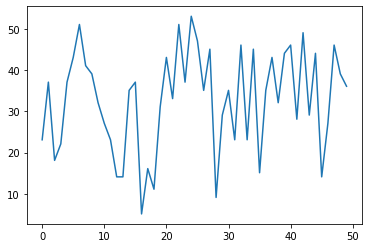

In [ ]:
history = []

# Optimize the argument values from the `foo_space`, to achieve larger return
# value.
for example, feedback in pg.sample(
    foo_space,
    pg.evolution.regularized_evolution(population_size=20, tournament_size=10),
    num_examples=50):
  assert isinstance(example, foo)
  reward = example()
  feedback(reward)
  history.append(reward)

import matplotlib.pyplot as plt
plt.plot(list(range(len(history))), [a - 0.9 for a in history])
plt.show()

<a name='functools-partial'></a>
## Appendix: Various Binding Scenarios with `functools.partial`

To allow users to compare functor with existing binding tools, we add this appendix to illustrate how certain binding scenarios are solved using `functools.partial`.

### Partial binding


In [ ]:
def foo(fn, v):
  return v + fn(v)

def bar(x, y):
  return x + y

import functools

# To fit the signature of `foo.fn`,
# we create a partial binding of bar.
foo(functools.partial(bar, y=2), 1)

4

### Incremental binding

In [ ]:
# Incremental binding can be achieved with nested `functools.partial`.
b = functools.partial(bar, x=1)
b2 = functools.partial(b, y=2)
print(b2)
print(b2())

functools.partial(<function bar at 0x7fece1932f70>, x=1, y=2)
3


### Mutable binding

In [ ]:
# Argument override can be achieved by creating another partial binding
# with overriden arguments.
b3 = functools.partial(b2, x=2)
print(b3)

# Or specifying a different value at call time.
b2(x=2)

functools.partial(<function bar at 0x7fece1932f70>, x=2, y=2)


4